## Import libraries

In [1]:
import pickle
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from simulation_framework.functions import bollinger_strategy
from scipy import stats

## Functions to get, manipulate and plot data

In [2]:
def get_data(filename, q_learning=False):
    with open(filename, 'rb') as handle:
        output_dict = pickle.load(handle)
    scores = output_dict["scores"]
    data = output_dict["data"]
    #setting = output_dict["setting"]
    if q_learning:
        return scores, data, 0, output_dict["q_tabular"]
    return scores, data, 0

def get_moving_avg(scores, window_size):
    numbers_series = pd.Series(scores)
    windows = numbers_series.rolling(window_size, min_periods=1)
    moving_averages = windows.mean()
    moving_averages_list = moving_averages.tolist()
    return moving_averages_list, [i for i in range(1,len(moving_averages_list)+1)]

def get_moving_std(scores, window_size):
    numbers_series = pd.Series(scores)
    windows = numbers_series.rolling(window_size, min_periods=1)
    moving_averages = windows.std()
    moving_averages_list = moving_averages.tolist()
    return moving_averages_list, [i for i in range(1,len(moving_averages_list)+1)]

def plot_avg(x_q, scores_q_avg, x_idqn, scores_idqn_avg,
             x_dqn, scores_dqn_avg, x_bb, scores_bb_avg):
    plt.plot(x_q, scores_q_avg, color="red", label="Q-Learning")
    plt.plot(x_idqn, scores_idqn_avg, color="blue", label="Interactive DQN")
    plt.plot(x_dqn, scores_dqn_avg, color="orange", label="DQN")
    plt.plot(x_bb, scores_bb_avg, color="green", label="Bollinger Bands")

    plt.legend(loc= "lower right", fontsize=13)
    plt.ylabel("PnL", fontsize=15)
    plt.xlabel("Episode", fontsize=15)
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)
    plt.title("Moving Average of PnL for Inventory Agents",
              fontsize=16)
    plt.show()

def plot_std(x_q, scores_q_std, x_idqn, scores_idqn_std,
             x_dqn, scores_dqn_std,x_bb, scores_bb_std):
    plt.plot(x_q, scores_q_std, color="red", label="Q-Learning")
    plt.plot(x_idqn, scores_idqn_std, color="blue", label="Interactive DQN")
    plt.plot(x_dqn, scores_dqn_std, color="orange", label="DQN")
    plt.plot(x_bb, scores_bb_std, color="green", label="Bollinger Bands")

    #plt.legend(loc= "upper right", fontsize=13)
    plt.ylabel("Standard Deviation", fontsize=15)
    plt.xlabel("Episode", fontsize=15)
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)
    plt.title("Moving Standard Deviation of PnL for Inventory Agents",
              fontsize=16)
    plt.show()

## Set up Bollinger bands as a benchmark

In [3]:
theta = 10.
mu = 0.
sigma = .20

T = 10.
N = 100
ts = np.linspace(0., T, N)
num_iter = 2_500
pnlss = bollinger_strategy(theta, mu, sigma, ts, num_iter)
scores_bb = [pnls[-1] for pnls in pnlss]

## Plot and compare PnL of Agents:
- Q learning
- Interactive Deep Q Network
- Normal Deep Q Network

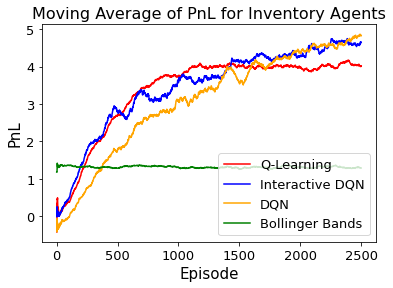

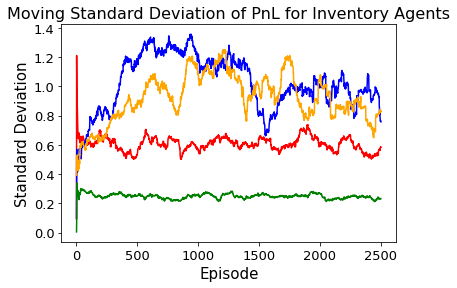

In [4]:
path = os.path.dirname(os.path.dirname(os.getcwd()))
filename_q = path + '\data\q_learning\q_learning_inv_output_action.pickle'
filename_idqn = path +  '\data\interactive_dqn\interactive_dqn_inv_bs_output.pickle'
filename_dqn = path + '\data\dqn\dqn_inv_output_act.pickle'

window_size = 100

scores_q, data_q, setting_q, q_tabular = get_data(filename_q, True)
scores_idqn, data_idqn, setting_idqn = get_data(filename_idqn, False)
scores_dqn, data_dqn, setting_dqn = get_data(filename_dqn, False)

scores_q_avg, x_q = get_moving_avg(scores_q, window_size)
scores_idqn_avg, x_idqn = get_moving_avg(scores_idqn, window_size)
scores_dqn_avg, x_dqn = get_moving_avg(scores_dqn, window_size)
scores_bb_avg, x_bb = get_moving_avg(scores_bb, window_size)

scores_q_std, _ = get_moving_std(scores_q, window_size)
scores_idqn_std, _ = get_moving_std(scores_idqn, window_size)
scores_dqn_std, _ = get_moving_std(scores_dqn, window_size)
scores_bb_std, _ = get_moving_std(scores_bb, window_size)

plot_avg(x_q, scores_q_avg, x_idqn, scores_idqn_avg, x_dqn, scores_dqn_avg, x_bb, scores_bb_avg)
plot_std(x_q, scores_q_std, x_idqn, scores_idqn_std, x_dqn, scores_dqn_std, x_bb, scores_bb_std)

## Functions for Decision Splitting Plots

In [5]:
def data_prep(data, dir, upper, lower):
    df = data[data["decision"]==int(dir)]
    data_temp = df[df["episode"]<=upper]
    data_temp_1 = data_temp[data_temp["episode"]>=lower]
    y = data_temp_1["price"].values
    kernel = stats.gaussian_kde(y)
    x_kde = np.linspace(min(y), max(y), 100)
    return y, kernel(x_kde), x_kde

def data_prep_loop(data, episodal_center= [50, 450, 1450], window_half = 50):
    y_ss = []
    y_s = []
    y_b = []
    y_bb = []
    y_kde_ss = []
    y_kde_s = []
    y_kde_b = []
    y_kde_bb = []
    x_kde_ss = []
    x_kde_s = []
    x_kde_b = []
    x_kde_bb = []
    for i in range(len(episodal_center)):
        upper = episodal_center[i] + window_half
        lower = episodal_center[i] - window_half
        y0, y_kde0, x_kde0 = data_prep(data, -2, upper, lower)
        y1, y_kde1, x_kde1 = data_prep(data, -1, upper, lower)
        y2, y_kde2, x_kde2 = data_prep(data, 1, upper, lower)
        y3, y_kde3, x_kde3 = data_prep(data, 2, upper, lower)
        y_ss.append(y0)
        y_s.append(y1)
        y_b.append(y2)
        y_bb.append(y3)
        y_kde_ss.append(y_kde0)
        y_kde_s.append(y_kde1)
        y_kde_b.append(y_kde2)
        y_kde_bb.append(y_kde3)
        x_kde_ss.append(x_kde0)
        x_kde_s.append(x_kde1)
        x_kde_b.append(x_kde2)
        x_kde_bb.append(x_kde3)

    return y_ss, y_s, y_b, y_bb,\
           y_kde_ss, y_kde_s, y_kde_b , y_kde_bb,\
           x_kde_ss, x_kde_s , x_kde_b, x_kde_bb

def decision_splitting(data, episodal_center, window_half, agent, dist=1):
    y_ss, y_s, y_b, y_bb, y_kde_ss, y_kde_s, y_kde_b, y_kde_bb ,x_kde_ss, x_kde_s ,x_kde_b, x_kde_bb = data_prep_loop(data, episodal_center, window_half)
    fig, axs = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(15,5))

    axs[0][0].plot(x_kde_bb[0], y_kde_bb[0], color="green")
    axs[0][0].hist(y_bb[0], density=True, bins=100, color="green", alpha=0.5, label="Double Buy")
    axs[0][0].plot(x_kde_b[0], y_kde_b[0], color="yellow")
    axs[0][0].hist(y_b[0], density=True, bins=100, color="yellow", alpha=0.5, label="Single Buy")
    axs[0][0].plot(x_kde_s[0], y_kde_s[0], color="orange")
    axs[0][0].hist(y_s[0], density=True, bins=100, color="orange", alpha=0.5, label="Single Sell")
    axs[0][0].plot(x_kde_ss[0], y_kde_ss[0], color="red")
    axs[0][0].hist(y_ss[0], density=True, bins=100, color="red", alpha=0.5, label="Double Sell")
    axs[0][0].legend(loc= "upper right", fontsize=16)
    axs[0][0].text(np.amin(y_b[0])*dist,15, 'Episodes ' + str(episodal_center[0]-window_half) +
                '-' + str(episodal_center[0]+window_half), fontsize=15)

    axs[0][1].plot(x_kde_bb[1], y_kde_bb[1], color="green")
    axs[0][1].hist(y_bb[1], density=True, bins=100, color="green", alpha=0.5, label="Double Buy")
    axs[0][1].plot(x_kde_b[1], y_kde_b[1], color="yellow")
    axs[0][1].hist(y_b[1], density=True, bins=100, color="yellow", alpha=0.5, label="Single Buy")
    axs[0][1].plot(x_kde_s[1], y_kde_s[1], color="orange")
    axs[0][1].hist(y_s[1], density=True, bins=100, color="orange", alpha=0.5, label="Single Sell")
    axs[0][1].plot(x_kde_ss[1], y_kde_ss[1], color="red")
    axs[0][1].hist(y_ss[1], density=True, bins=100, color="red", alpha=0.5, label="Double Sell")
    #axs[0][1].legend(loc= "upper right", fontsize=12)
    axs[0][1].text(np.amin(y_b[0])*dist,15, 'Episodes ' + str(episodal_center[1]-window_half) +
                '-' + str(episodal_center[1]+window_half), fontsize=15)

    axs[1][0].plot(x_kde_bb[2], y_kde_bb[2], color="green")
    axs[1][0].hist(y_bb[2], density=True, bins=100, color="green", alpha=0.5, label="Double Buy")
    axs[1][0].plot(x_kde_b[2], y_kde_b[2], color="yellow")
    axs[1][0].hist(y_b[2], density=True, bins=100, color="yellow", alpha=0.5, label="Single Buy")
    axs[1][0].plot(x_kde_s[2], y_kde_s[2], color="orange")
    axs[1][0].hist(y_s[2], density=True, bins=100, color="orange", alpha=0.5, label="Single Sell")
    axs[1][0].plot(x_kde_ss[2], y_kde_ss[2], color="red")
    axs[1][0].hist(y_ss[2], density=True, bins=100, color="red", alpha=0.5, label="Double Sell")
    #axs[1][0].legend(loc= "upper right", fontsize=12)
    axs[1][0].text(np.amin(y_b[0])*dist,15, 'Episodes ' + str(episodal_center[2]-window_half) +
                '-' + str(episodal_center[2]+window_half), fontsize=16)

    axs[1][1].plot(x_kde_bb[3], y_kde_bb[3], color="green")
    axs[1][1].hist(y_bb[3], density=True, bins=100, color="green", alpha=0.5, label="Double Buy")
    axs[1][1].plot(x_kde_b[3], y_kde_b[3], color="yellow")
    axs[1][1].hist(y_b[3], density=True, bins=100, color="yellow", alpha=0.5, label="Single Buy")
    axs[1][1].plot(x_kde_s[3], y_kde_s[3], color="orange")
    axs[1][1].hist(y_s[3], density=True, bins=100, color="orange", alpha=0.5, label="Single Sell")
    axs[1][1].plot(x_kde_ss[3], y_kde_ss[3], color="red")
    axs[1][1].hist(y_ss[3], density=True, bins=100, color="red", alpha=0.5, label="Double Sell")
    #axs[1][1].legend(loc= "upper right", fontsize=12)
    axs[1][1].text(np.amin(y_b[0])*dist,15, 'Episodes ' + str(episodal_center[3]-window_half) +
                '-' + str(episodal_center[3]+window_half), fontsize=15)

    axs[0][0].set_title('Action Splitting of ' + str(agent) + ' Agent', fontsize=18)
    axs[0][1].set_title('Action Splitting of ' + str(agent) + ' Agent', fontsize=18)
    axs[1][0].set_ylabel('Density', fontsize=18)
    axs[0][0].set_ylabel('Density', fontsize=18)
    axs[1][0].set_xlabel('Ornstein-Uhlenbeck Process', fontsize=18)
    axs[1][1].set_xlabel('Ornstein-Uhlenbeck Process', fontsize=18)
    fig.tight_layout()

    plt.show()

## Q Learning
#### Setting:

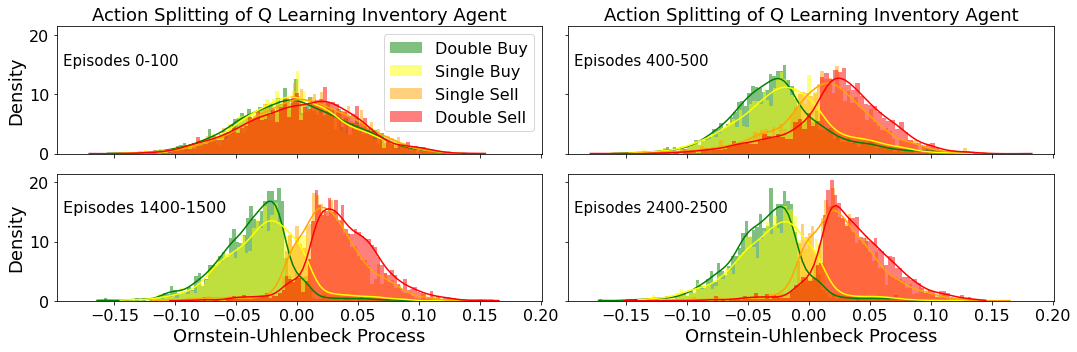

In [6]:
import matplotlib
matplotlib.rc('xtick', labelsize=16)
matplotlib.rc('ytick', labelsize=16)

episodal_center = [50, 450, 1450, 2450]
window_half = 50
decision_splitting(data_q, episodal_center, window_half, "Q Learning Inventory", 1.35)

## Interactive Deep Q Learning

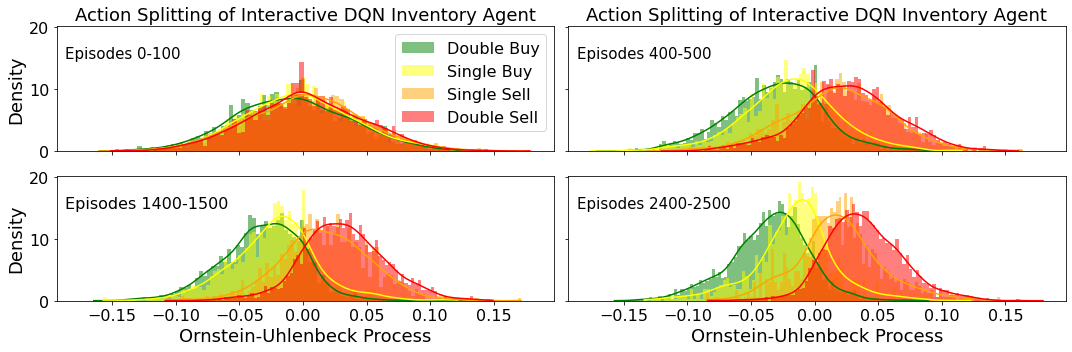

In [7]:
decision_splitting(data_idqn, episodal_center, window_half, "Interactive DQN Inventory", 1.25)

## Normal Deep Q Learning

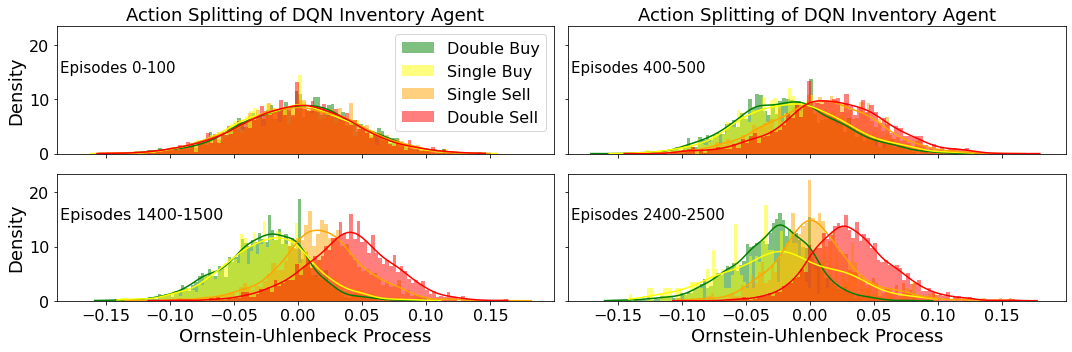

In [8]:
decision_splitting(data_dqn, episodal_center, window_half, "DQN Inventory", 1.15)


## Function to Plot single process

In [9]:
def recreate_pnl(data):
    pnls=[0]
    cash = 0
    Xs = data["price"].values
    action = data["decision"].values
    exp = data["exposure"].values

    for i in range(len(data)-1):
        cash -= int(action[i])*Xs[i]
        pnl = cash + exp[i + 1]*Xs[i + 1]
        pnls.append(pnl)

    return pnls

def plot_episodes(data, episodes=[1,2500]):
    df = data[data["episode"] == episodes[0]-1]
    pnls = recreate_pnl(df)
    df_ss = df[df["decision"]==-2]
    df_s = df[df["decision"]==-1]
    df_b = df[df["decision"]==1]
    df_bb = df[df["decision"]==2]

    fig, ax = plt.subplots(1,2 ,sharey=True, figsize=(15,5))

    ax[0].plot(df["time"] - min(df["time"]), df["price"], color="grey", alpha=0.5, label="Price process")
    ax[0].scatter(df_ss["time"] - min(df["time"]), df_ss["price"], color="red", label="Double Sell",
                marker= "v", s=100)
    ax[0].scatter(df_s["time"] - min(df["time"]), df_s["price"], color="orange", label="Single Sell",
                marker= "v", s=60)
    ax[0].scatter(df_b["time"] - min(df["time"]), df_b["price"], color="yellow", label="Single Buy",
                marker= "v", s=60)
    ax[0].scatter(df_bb["time"] - min(df["time"]), df_bb["price"], color="green", label="Double Buy",
                marker= "^", s=100)
    ax[0].set_xlabel("Time", fontsize=18)
    ax[0].set_ylabel("Ornstein-Uhlenbeck process", fontsize=18)
    ax[0].set_title("Episode " + str(episodes[0]), fontsize=20)
    ax[0].legend(loc="lower left",fontsize=14)

    ax1 = ax[0].twinx()
    ax1.plot(df["time"] - min(df["time"]), pnls, color="black", label="PnL",linewidth=2)
    #ax1.plot(df["time"] - min(df["time"]), df["exposure"], color="blue", alpha=0.2,label="Exposure",linewidth=2)
    ax1.set_ylim((-6,6))
    ax1.set_yticks([])
    ax1.legend(loc="upper left",fontsize=14)

    df = data[data["episode"] == episodes[1]-1]
    pnls = recreate_pnl(df)
    df_ss = df[df["decision"]==-2]
    df_s = df[df["decision"]==-1]
    df_b = df[df["decision"]==1]
    df_bb = df[df["decision"]==2]

    ax[1].plot(df["time"] - min(df["time"]), df["price"], color="grey", alpha=0.5, label="Price process")
    ax[1].scatter(df_ss["time"] - min(df["time"]), df_ss["price"], color="red", label="Double Sell",
                marker= "v", s=100)
    ax[1].scatter(df_s["time"] - min(df["time"]), df_s["price"], color="orange", label="Single Sell",
                marker= "v", s=60)
    ax[1].scatter(df_b["time"] - min(df["time"]), df_b["price"], color="yellow", label="Single Buy",
                marker= "v", s=60)
    ax[1].scatter(df_bb["time"] - min(df["time"]), df_bb["price"], color="green", label="Double Buy",
                marker= "^", s=100)
    ax[1].set_xlabel("Time", fontsize=18)
    #ax[1].set_ylabel("Ornstein-Uhlenbeck process", fontsize=18)
    ax[1].set_title("Episode " + str(episodes[1]), fontsize=20)
    #ax[1].legend(loc="lower left",fontsize=13)

    ax2 = ax[1].twinx()
    ax2.plot(df["time"] - min(df["time"]), pnls, color="black", label="PnL",linewidth=2)
    #ax2.plot(df["time"] - min(df["time"]), df["exposure"], color="blue", alpha=0.2,label="Exposure",linewidth=2)
    ax2.set_ylabel("PnL", fontsize=18)
    ax2.set_ylim((-6,6))
    #ax2.set_yticks([])
    #ax2.legend(loc="upper left",fontsize=13)

    plt.tight_layout()
    plt.show()

## Compare Investment process of two episodes

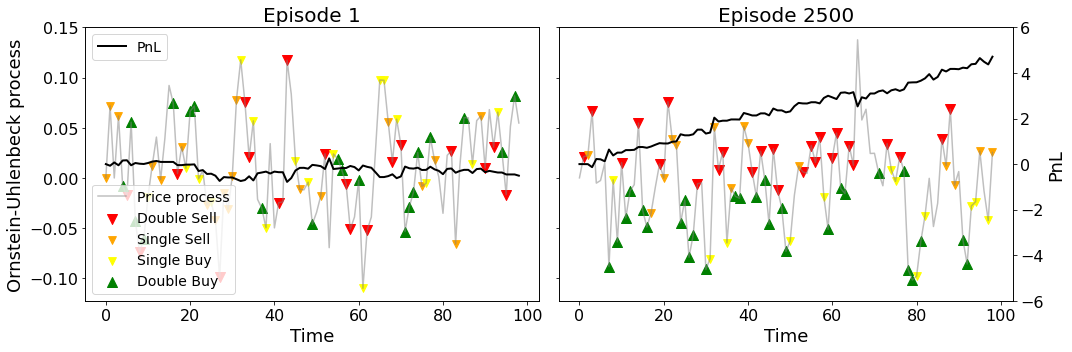

In [10]:
matplotlib.rc('xtick', labelsize=16)
matplotlib.rc('ytick', labelsize=16)

plot_episodes(data_q, episodes=[1,2500] )

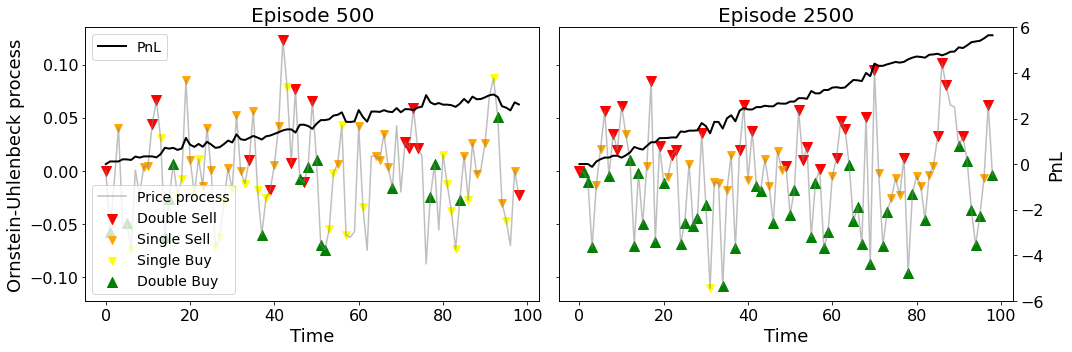

In [11]:
plot_episodes(data_dqn, episodes=[500,2500])

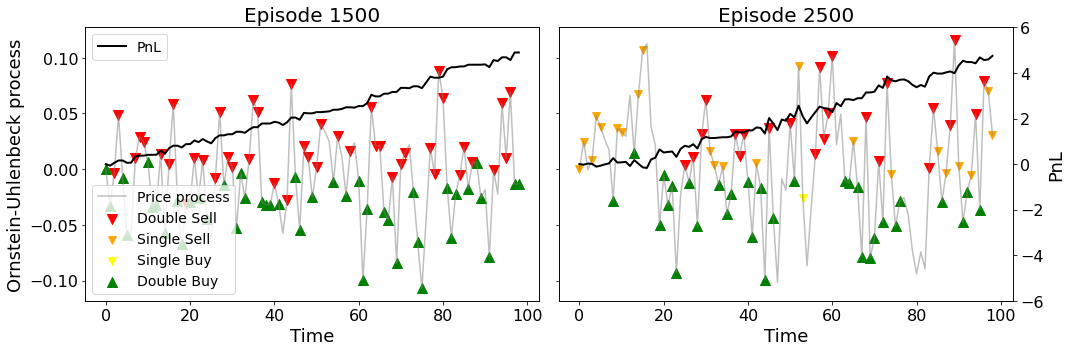

In [12]:
plot_episodes(data_idqn, episodes=[1500,2500])


## Function to gather Statistics of the different Agents

In [13]:
def stats_gatherer(data, scores, name, episodes):
    print(str(name))
    result_dict = {}
    for tuple in episodes:
        temp_dict = {}
        df = data[data["episode"] >= tuple[0]]
        df_1 = df[df["episode"] < tuple[1]]
        numb = len(df_1[df_1["decision"] != int(0)])
        scores_1 = scores[tuple[0]:tuple[1]]


        temp_dict["Avg_PnL"]= np.mean(scores_1)
        temp_dict["Std_PnL"]= np.std(scores_1)
        #temp_dict["Med_PnL"]= np.quantile(scores_1, 0.5)
        temp_dict["inv_per_episode"] = numb/ (tuple[1]-tuple[0])
        temp_dict["profit_per_exp_change"] = np.sum(scores_1)/numb

        #temp_dict["ds"] = len(df_1[df_1["decision"] == int(-2)])/len(df_1)
        #temp_dict["s"] = len(df_1[df_1["decision"] == int(-1)])/len(df_1)
        #temp_dict["n"] = len(df_1[df_1["decision"] == int(0)])/len(df_1)
        #temp_dict["b"] = len(df_1[df_1["decision"] == int(1)])/len(df_1)
        #temp_dict["db"] = len(df_1[df_1["decision"] == int(2)])/len(df_1)
        print(temp_dict)

        result_dict[str(tuple)] = temp_dict
    return result_dict

In [14]:
episodes = [(0,100), (400,500), (1400,1500), (2000,2100), (2400,2500)]
result_q = stats_gatherer(data_q, scores_q, "Q Learning",
                          episodes= episodes)
result_dqn = stats_gatherer(data_dqn, scores_dqn, "DQN",
                          episodes= episodes)
result_idqn = stats_gatherer(data_idqn, scores_idqn, "Interactive DQN",
                          episodes= episodes)


Q Learning
{'Avg_PnL': 0.37408410888795046, 'Std_PnL': 0.6114539485627607, 'inv_per_episode': 77.32, 'profit_per_exp_change': 0.004838128671597911}
{'Avg_PnL': 2.6841962916329294, 'Std_PnL': 0.5286547962348337, 'inv_per_episode': 78.4, 'profit_per_exp_change': 0.03423719759735879}
{'Avg_PnL': 4.01138258654892, 'Std_PnL': 0.640401327494786, 'inv_per_episode': 74.37, 'profit_per_exp_change': 0.053938181881792654}
{'Avg_PnL': 3.9184528640887715, 'Std_PnL': 0.5810886831879688, 'inv_per_episode': 74.1, 'profit_per_exp_change': 0.052880605453289764}
{'Avg_PnL': 4.018501425663783, 'Std_PnL': 0.5818863462514063, 'inv_per_episode': 74.63, 'profit_per_exp_change': 0.05384565758627607}
DQN
{'Avg_PnL': -0.030174555309756518, 'Std_PnL': 0.6246574169761979, 'inv_per_episode': 77.79, 'profit_per_exp_change': -0.00038789761292912353}
{'Avg_PnL': 1.7701775773262023, 'Std_PnL': 0.868464796261308, 'inv_per_episode': 76.62, 'profit_per_exp_change': 0.023103335647692538}
{'Avg_PnL': 3.5457552519454056, 'St

## Function to generate rolling discrete action distribution

In [15]:
def discrete_dist(data, scores):
    ss=[]
    s=[]
    n=[]
    b=[]
    bb=[]
    pnl=[]
    eps =[]
    epsilon=1
    for i in range(2400):
        df = data[data["episode"] >= i]
        df_1 = df[df["episode"] < i+100]
        ss.append(len(df_1[df_1["decision"] == int(-2)])/len(df_1))
        s.append(len(df_1[df_1["decision"] == int(-1)])/len(df_1))
        n.append(len(df_1[df_1["decision"] == int(0)])/len(df_1))
        b.append(len(df_1[df_1["decision"] == int(1)])/len(df_1))
        bb.append(len(df_1[df_1["decision"] == int(2)])/len(df_1))
        pnl.append(np.mean(scores[i:i+100]))
        eps.append(max(0.01, epsilon))
        epsilon *= 0.998
    return ss, s, n, b, bb, eps


In [16]:
ss_q, s_q, n_q, b_q, bb_q, eps_q = discrete_dist(data_q, scores_q)
ss_dqn, s_dqn, n_dqn, b_dqn, bb_dqn, eps_dqn = discrete_dist(data_dqn, scores_dqn)
ss_idqn, s_idqn, n_idqn, b_idqn, bb_idqn, eps_idqn = discrete_dist(data_idqn, scores_idqn)

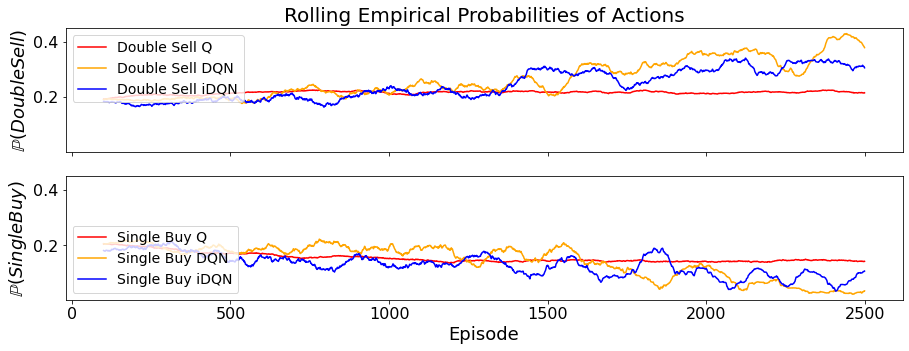

In [17]:
matplotlib.rc('xtick', labelsize=16)
matplotlib.rc('ytick', labelsize=16)

x= [i for i in range(100,2500)]
fig, ax = plt.subplots(2,1 , sharex=True,sharey=True, figsize=(15,5))

ax[0].plot(x, ss_q, label="Double Sell Q", color="red")
ax[0].plot(x, ss_dqn,  label="Double Sell DQN", color="orange")
ax[0].plot(x, ss_idqn,  label="Double Sell iDQN", color="blue")
ax[0].legend(loc="upper left",fontsize=14)
ax[0].set_ylabel(r"$\mathbb{P}(Double Sell)$", fontsize=18)

ax[1].plot(x, b_q, label="Single Buy Q", color="red")
ax[1].plot(x, b_dqn,  label="Single Buy DQN", color="orange")
ax[1].plot(x, b_idqn,  label="Single Buy iDQN", color="blue")
ax[1].set_ylabel(r"$\mathbb{P}(Single Buy)$", fontsize=18)
ax[1].legend(loc="lower left",fontsize=14)

ax[0].set_title("Rolling Empirical Probabilities of Actions", fontsize=20)
ax[1].set_xlabel("Episode", fontsize=18)
plt.show()

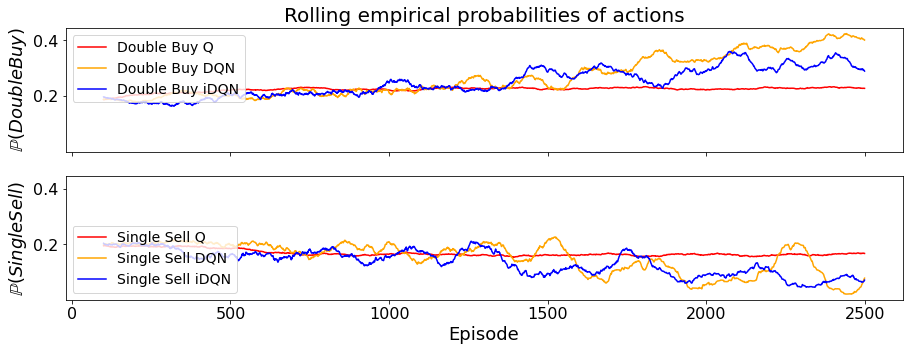

In [18]:
matplotlib.rc('xtick', labelsize=16)
matplotlib.rc('ytick', labelsize=16)

x= [i for i in range(100,2500)]
fig, ax = plt.subplots(2,1 , sharex=True,sharey=True, figsize=(15,5))

ax[0].plot(x, bb_q, label="Double Buy Q", color="red")
ax[0].plot(x, bb_dqn,  label="Double Buy DQN", color="orange")
ax[0].plot(x, bb_idqn,  label="Double Buy iDQN", color="blue")
ax[0].legend(loc="upper left",fontsize=14)
ax[0].set_ylabel(r"$\mathbb{P}(Double Buy)$", fontsize=18)

ax[1].plot(x, s_q, label="Single Sell Q", color="red")
ax[1].plot(x, s_dqn,  label="Single Sell DQN", color="orange")
ax[1].plot(x, s_idqn,  label="Single Sell iDQN", color="blue")
ax[1].set_ylabel(r"$\mathbb{P}(Single Sell)$", fontsize=18)
ax[1].legend(loc="lower left",fontsize=14)

ax[0].set_title("Rolling empirical probabilities of actions", fontsize=20)
ax[1].set_xlabel("Episode", fontsize=18)
plt.show()


